<a href="https://colab.research.google.com/github/Himagination/TensorFlow_Developer/blob/main/04_Transfer_Learning_Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Why use Transfer Learning?**

* Can Leverage an existing neural network architecture proven to work on problems similar to our own.
* Can leverage a working network architecture which has already learned patterns on similar data to our own(often results in great results with less data)


## Download and becoming one with data

In [1]:
# get data(10% of food dataset)
import os
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-04-13 06:51:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.8.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.8.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   129MB/s    in 1.2s    

2022-04-13 06:51:36 (129 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder?

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/test'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen

## Create dataloaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batch

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir, 
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE, 
                                                          class_mode='categorical')
print("Test images:")

test_data = test_datagen.flow_from_directory(test_dir, 
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE, 
                                             class_mode='categorical')

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback.
* Model checkpoint with the ModelCheckpoint callback.
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [5]:
# create TensorBoard callback

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow hub

In the past we've used to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layer are going to come from TensorFlow Hub.

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Import dependencies
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's compare the following two model
resnet_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [8]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default to 10.

    Returns:
      An uncompiled Keras Sequential model with model_url as feature extrctor
      layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, 
                                           name='feature_extraction_layer', 
                                           input_shape=IMAGE_SHAPE+(3, )) # Freeze already learnt patterns
  # Create the model
  model = tf.keras.Sequential([
                               feature_extractor_layer, 
                               layers.Dense(num_classes, 
                                            activation='softmax', 
                                            name='output_layer')
  ])

  return model                 


### Creating and testing ResNet TensorFlow Hub Feature Extraction model.

In [9]:
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23561152  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


In [11]:
# Compile our resnet model
resnet_model.compile(loss='categorical_crossentropy', 
                     optimizer=tf.keras.optimizers.Adam(), 
                     metrics=['accuracy'])

In [12]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent, 
                 epochs=5, 
                 steps_per_epoch=len(train_data_10_percent), 
                 validation_data=test_data, 
                 validation_steps=len(test_data), 
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                        experiment_name='resnet20V2')])

Saving Tensorboard log files to: tensorflow_hub/resnet20V2/20220413-070245
Epoch 1/5
24/24 [==============================] - 43s 1s/step - loss: 2.0106 - accuracy: 0.3467 - val_loss: 1.0772 - val_accuracy: 0.6616
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.8754 - accuracy: 0.7320 - val_loss: 0.7380 - val_accuracy: 0.7668
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.5778 - accuracy: 0.8253 - val_loss: 0.6153 - val_accuracy: 0.8112
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.4372 - accuracy: 0.8960 - val_loss: 0.5743 - val_accuracy: 0.8164
Epoch 5/5
24/24 [==============================] - 24s 1s/step - loss: 0.3430 - accuracy: 0.9293 - val_loss: 0.5708 - val_accuracy: 0.8180


Our Transfer Learning Feature Extractor model out performed ALL of the previous models we built by hand...(substantially) and in a quicker training time AND with only 10% of the training examples.

In [13]:
# Let's create function to plot loss curve
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  
  Args:
    history: TensorFlow History object

  Returns:
    Plots of training/validation loss and accuracy metrics.  
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='validation_loss')
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='validation_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

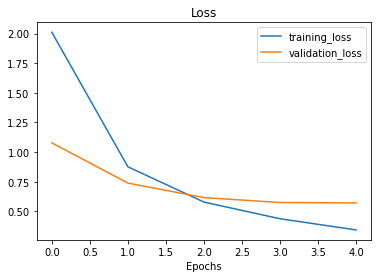

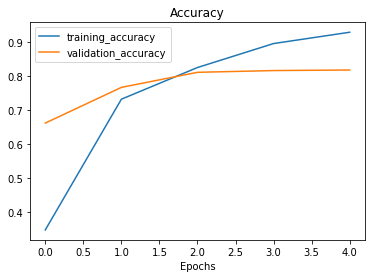

In [14]:
plot_loss_curves(resnet_history)

### Creating and Testing EfficientNet80 TensorFlow Hub Feature Extraction model.

In [15]:
# Create EfficientNet80 feature extractor model
efficientnet80_model = create_model(efficientnet_url, 
                                    train_data_10_percent.num_classes)

In [16]:
# Compile the model
efficientnet80_model.compile(loss='categorical_crossentropy', 
                             optimizer=tf.keras.optimizers.Adam(), 
                             metrics=['accuracy'])

# Fit the model
efficientnet80_history = efficientnet80_model.fit(train_data_10_percent, 
                         epochs=5, 
                         steps_per_epoch=len(train_data_10_percent), 
                         validation_data=test_data, 
                         validation_steps=len(test_data), 
                         callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', 
                                                                experiment_name='efficientnetb0')])

Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20220413-072724
Epoch 1/5
24/24 [==============================] - 32s 892ms/step - loss: 1.9654 - accuracy: 0.3853 - val_loss: 1.3839 - val_accuracy: 0.6920
Epoch 2/5
24/24 [==============================] - 19s 805ms/step - loss: 1.1092 - accuracy: 0.7587 - val_loss: 0.9049 - val_accuracy: 0.8124
Epoch 3/5
24/24 [==============================] - 19s 803ms/step - loss: 0.7759 - accuracy: 0.8293 - val_loss: 0.7194 - val_accuracy: 0.8300
Epoch 4/5
24/24 [==============================] - 19s 797ms/step - loss: 0.6195 - accuracy: 0.8613 - val_loss: 0.6225 - val_accuracy: 0.8484
Epoch 5/5
24/24 [==============================] - 19s 804ms/step - loss: 0.5182 - accuracy: 0.8947 - val_loss: 0.5651 - val_accuracy: 0.8596


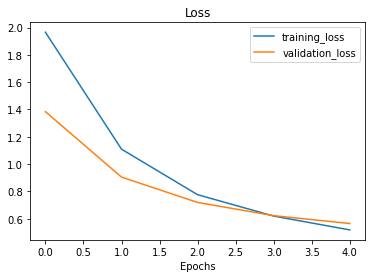

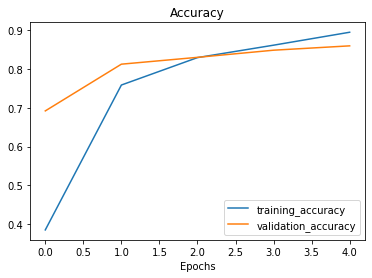

In [17]:
plot_loss_curves(efficientnet80_history)

In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23561152  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


### Types of Transfer Learning

* 'As is' transfer learning - Using an existing model with no changes what so ever(e.g. using `ImageNet` model on 1000 ImageNet classes none of our own.
* 'Feature Extraction' transfer learning - Use the pre-learned patterns of an existing model (eg. EfficientNet50 trained on ImageNet) and adjust the output layer for your own problem(eg 1000 classes -> 10 classes of food)
* 'Fine-tuning' transfer learning - use the prelearned patterns of an existing model and 'fine-tune' many or all of the underlying layers (including new output layers)



## Comparing our models result using TensorBoard

**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments(things you don't want others to see) do not upload them to TensorBoard.dev

In [19]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ --name 'EfficientNet50 vs. ResNet50V2' \
--description 'Comparing two different TF Hub feature extraction model architectures' --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=gwQrFIoyL55IGNM8GqbRUbsbD5SaGd&prompt=consent&access_type=off

Our TensorBoard experiment are uploaded publicly at https://tensorboard.dev/experiment/0qZcziRASaWWY9Cn3P7kAw/

In [20]:
!tensorboard dev list

https://tensorboard.dev/experiment/9oYzkF3BRXaZLMHbBBs9NA/
	Name                 EfficientNet50 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   9oYzkF3BRXaZLMHbBBs9NA
	Created              2022-04-13 07:32:13 (1 minute ago)
	Updated              2022-04-13 07:32:18 (1 minute ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6647603
https://tensorboard.dev/experiment/0qZcziRASaWWY9Cn3P7kAw/
	Name                 EfficientNet50 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures
	Id                   0qZcziRASaWWY9Cn3P7kAw
	Created              2022-01-18 14:00:04
	Updated              2022-01-18 14:00:07
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  10729747
Total: 2 experiment(s)
